In [1]:
from src.data.paths import project_dir
from src.data.analysis import Circle, create_circular_mask
from src.data.detector import find_circle_hough_method, img_for_circle_detection
from src.data.detector import find_circle_hough_method, img_for_circle_detection, DetectorDataCollection, DetectorData, DetectorImage

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from scipy.ndimage import center_of_mass

from dataclasses import dataclass, field
from pathlib import Path

import tifffile 

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

# Data structures

In [2]:
# @dataclass(frozen=True)
# class DetectorImage:
#     image: np.ndarray
#     path: Path

#     @property
#     def init_circle(self) -> Circle:
#         return Circle(x=self.image.shape[0]//2, y=self.image.shape[1]//2, r=100)

# @dataclass(frozen=True)
# class DetectorData:
#     raw: DetectorImage
#     lv: DetectorImage
#     det_no: int
#     circle: Circle = field(default=Circle())

@dataclass(frozen=True)
class TupleXY:
    x: float
    y: float

@dataclass(frozen=True)
class CuttingParameters:
    foil_init_center: TupleXY
    foil_init_size: TupleXY = field(default=TupleXY(120, 120))
    cut_px: int = 100
    r_envelope_start: int = 150
    max_radius: int = 70
    min_radius: int = 30

# EBT3 Calibration

In [3]:
@dataclass
class Calibration:
    a0 : float = 0
    a1 : float = 0
    a2 : float = 0
    a3 : float = 0

    def __call__(self, x):
        return self.a0 + self.a1*x + self.a2*x**2 + self.a3*x**3

    def __repr__(self):
        result = f'f(x) = '
        first_item = True
        if self.a0 != 0:
            result += f'{self.a0}'
            if first_item:
                first_item = False
            else:
                result += ' +'
        if self.a1 != 0:
            if first_item:
                first_item = False
            else:
                result += ' +'
            result += f' {self.a1}*x'
        if self.a2 != 0:
            if first_item:
                first_item = False
            else:
                result += ' +'
            result += f' {self.a2}*x^2'
        if self.a3 != 0:
            if first_item:
                first_item = False
            else:
                result += ' +'
            result += f' {self.a3}*x^3'
        return result

ebt3_proton_calib_20Gy = Calibration(a1=9.62189, a3=78.75125)
ebt3_proton_calib_20Gy

f(x) =  9.62189*x + 78.75125*x^3

In [4]:
netOD_test = 0.28
ebt3_proton_calib_20Gy(netOD_test)

4.422876640000001

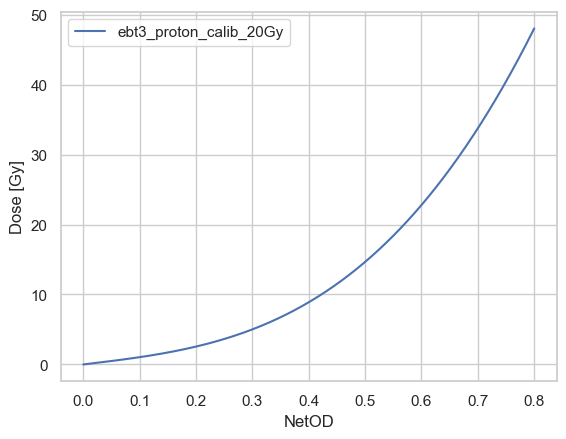

In [5]:
netOD_plot = np.linspace(0, 0.8, 800)

fig, ax = plt.subplots()
ax.plot(netOD_plot, ebt3_proton_calib_20Gy(netOD_plot), label='ebt3_proton_calib_20Gy')
ax.set_xlabel('NetOD')
ax.set_ylabel('Dose [Gy]')
ax.legend()

# EBT3 20 Gy entrance data loading

In [6]:
base_path = Path.home() / 'OneDrive - ifj.edu.pl' / 'Projects' / 'MB_foils'
base_path.exists()

False

In [7]:
image_path = base_path / 'publication_Measurement_2024' / 'data_for_plots' / 'skan139.tif'
image_path.exists()

False

In [8]:
image_path = Path("/home/grzanka/workspace/osl_mb_foils/data/raw/2024-12-12/img023.tif")

In [9]:
#image_path = Path('../../skan139.tif')
image_path.exists()

True

In [10]:
def net_optical_density(image: np.ndarray, channel_no : int = 0) -> np.ndarray:
    bg_r = 42804.451 
    bg_g = 44273.485
    bg_b = 27929.477 
    bg = [bg_r, bg_g, bg_b]
    return np.log10(bg[channel_no] / image[:, :, channel_no])

In [11]:
def ebt3_dose_Gy(image: np.ndarray, calib: Calibration = ebt3_proton_calib_20Gy, channel_no : int = 0) -> np.ndarray:
    return calib(net_optical_density(image, channel_no))

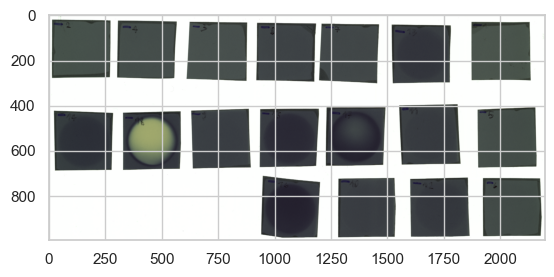

In [12]:
im = tifffile.imread(image_path)
im.shape, im.dtype
plt.imshow(im / im.max(), cmap='gray')

In [13]:
net_optical_density(im).min(), net_optical_density(im).max()

(-0.18498437250366387, 1.0754277722520533)

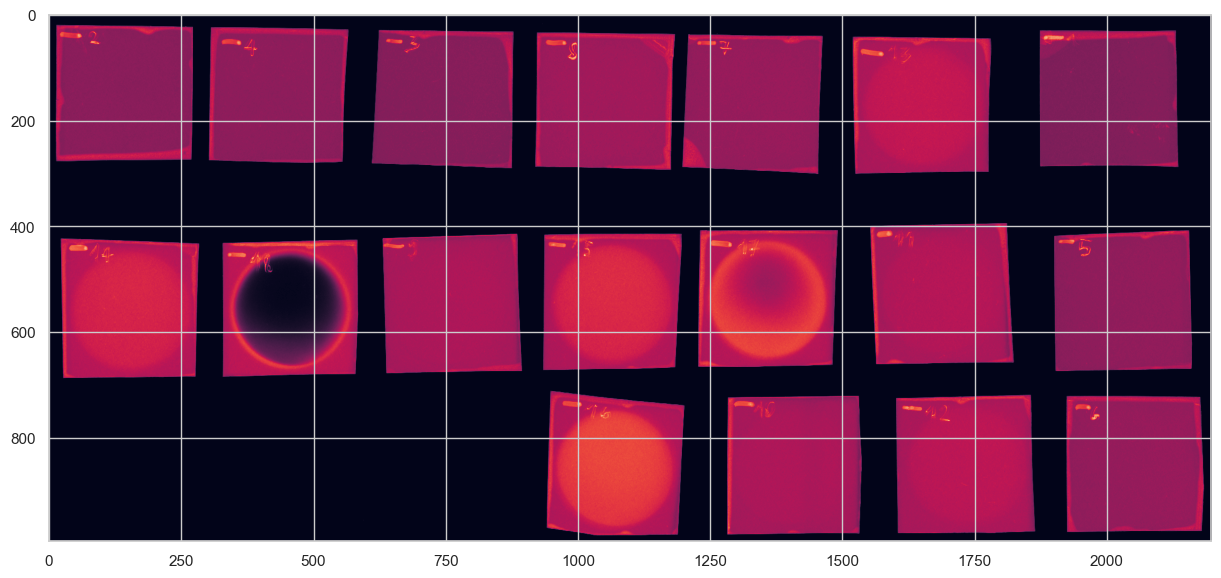

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(np.where(net_optical_density(im) < 0, 0, net_optical_density(im)))
#plt.colorbar()

## Single foil tests

### Foil selection

In [115]:
foil_init_center = (950, 2100)
foil_init_dx = 150
foil_init_dy = 150
foil_cut1 = im[foil_init_center[0]-foil_init_dx:foil_init_center[0]+foil_init_dx,
             foil_init_center[1]-foil_init_dy:foil_init_center[1]+foil_init_dy]

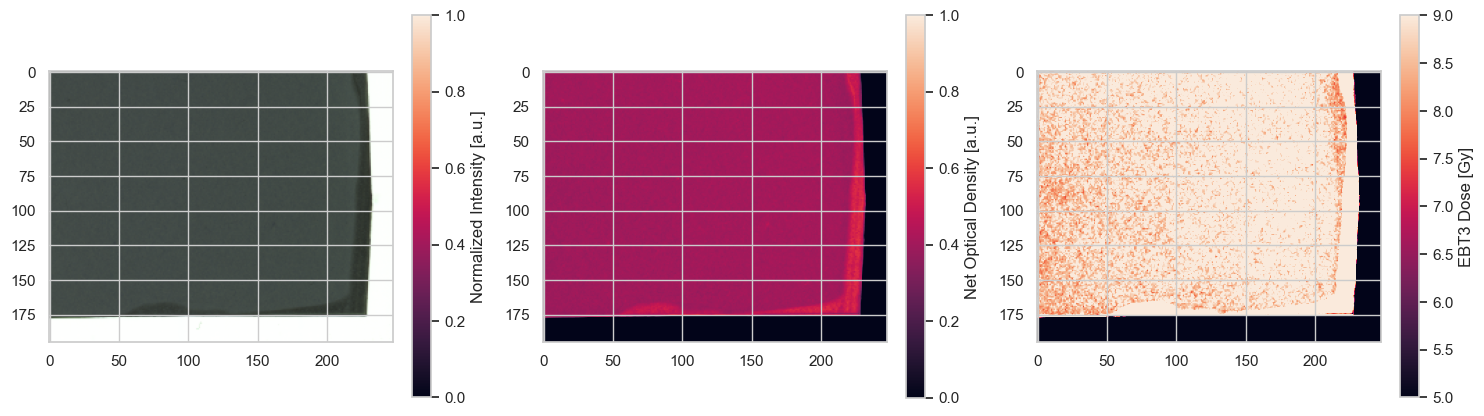

In [116]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), facecolor='none')
im1 = axs[0].imshow(foil_cut1 / foil_cut1.max(), vmin=0, vmax=1.0)
im2 = axs[1].imshow(net_optical_density(foil_cut1), vmin=0, vmax=1.0)
im3 = axs[2].imshow(ebt3_dose_Gy(foil_cut1), vmin=5, vmax=9)

fig.colorbar(im1, label='Normalized Intensity [a.u.]', fraction=0.05)
fig.colorbar(im2, label='Net Optical Density [a.u.]', fraction=0.05)
fig.colorbar(im3, label='EBT3 Dose [Gy]', fraction=0.05)

plt.tight_layout()

#fig.savefig(base_path / '2024-05-28_PB_silicon_20Gy' / 'data'  / 'interim' / 'PB_20Gy' / 'ebt3_method.svg')

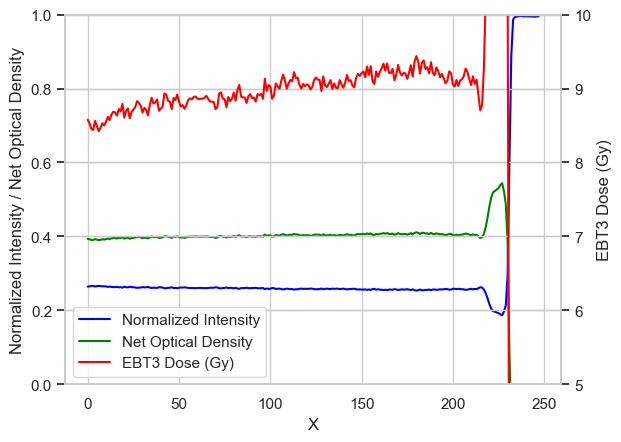

In [117]:
fig, ax = plt.subplots()
x_slice = slice(100,150)
ax.plot((foil_cut1 / foil_cut1.max())[x_slice, :, 0].mean(axis=0), label='Normalized Intensity', color='blue')
ax.plot(net_optical_density(foil_cut1)[x_slice, :].mean(axis=0), label='Net Optical Density', color='green')
ax_twin = ax.twinx()
ax_twin.plot(ebt3_dose_Gy(foil_cut1)[x_slice, :].mean(axis=0), label='EBT3 Dose (Gy)', color='red')
ax.set_xlabel('X')
ax.set_ylabel('Normalized Intensity / Net Optical Density')
ax_twin.set_ylabel('EBT3 Dose (Gy)')
ax.set_ylim(0, 1)
ax_twin.set_ylim(5, 10)
# legend for ax and ax_twin
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
ax_twin.legend(lines + lines2, labels + labels2, loc=0)


### Detector cutting

In [55]:
dpi = 300
ebt_px_to_mm = 25.4 / dpi
ebt_px_to_mm

0.08466666666666667

r_envelope = 150.00, vmax = 17.70


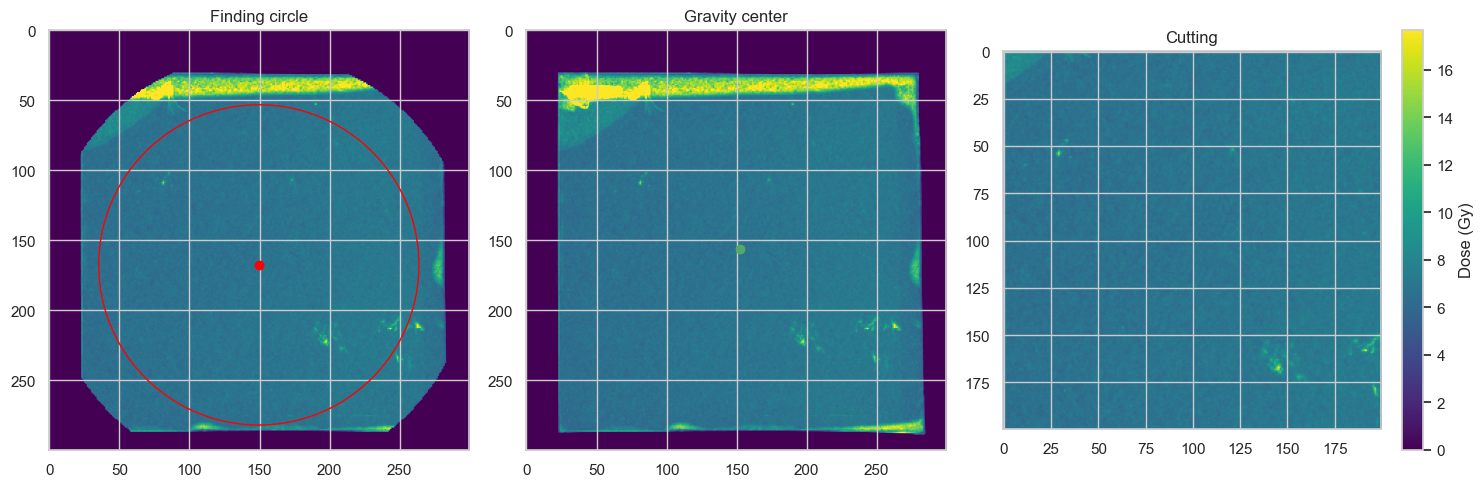

In [56]:
data = ebt3_dose_Gy(foil_cut1)[:,:]

# finding circle
data_for_circle = data.copy()
lv_for_detect = img_for_circle_detection(data_for_circle, nsigma=1)
circle = find_circle_hough_method(lv_for_detect, max_radius=180, min_radius=50)
vmin =  0
r_envelope = min(1.5*circle.r, 150)
mask = create_circular_mask(data_for_circle, Circle(x=circle.x, y=circle.y, r=r_envelope))
vmax = 1.1*np.percentile(data_for_circle[mask], 99)
data_for_circle[~mask] = 0
print(f"r_envelope = {r_envelope:.2f}, vmax = {vmax:.2f}")

# finding center of mass
data_for_cm = data_for_circle.copy()
cm = center_of_mass(data_for_cm)

# detector cutting
cut_px = 100
low_y = int(max(0, cm[0] - cut_px))
high_y = int(min(data.shape[0], cm[0] + cut_px))
low_x = int(max(0, cm[1] - cut_px))
high_x = int(min(data.shape[1], cm[1] + cut_px))
data_cut = data[low_y:high_y, low_x:high_x]

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

im1 = axs[0].imshow(data_for_circle, cmap='viridis', vmin=0, vmax=vmax)
axs[0].plot(circle.x, circle.y, 'o', color='red')
axs[0].add_artist(
    plt.Circle(xy=(circle.x, circle.y),
               radius=circle.r,
               color='red',
               fill=False,
               transform=axs[0].transData))
axs[0].set_title('Finding circle')

im2 = axs[1].imshow(data, cmap='viridis', vmin=0, vmax=vmax)
axs[1].scatter(cm[1], cm[0], color='g');
axs[1].set_title('Gravity center')

im3 = axs[2].imshow(data_cut, cmap='viridis', vmin=0, vmax=vmax)
axs[2].set_title('Cutting')

fig.colorbar(im3, label='Dose (Gy)', fraction=0.05)

plt.tight_layout()

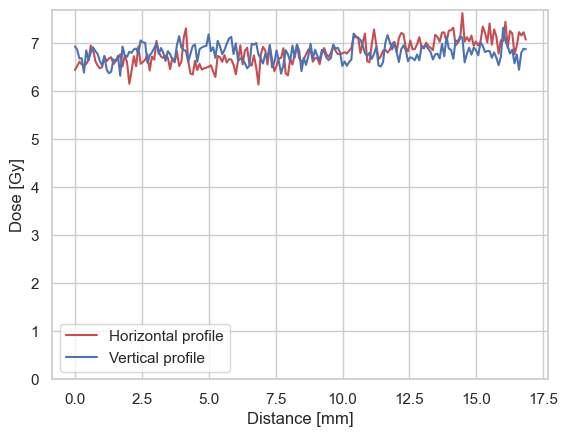

In [57]:
# plot horizontal and vertical profiles
profile_dx = 5
# plot as function of distance in mm, assuming 300dpi
res = 300
y_data = np.mean(data_cut[data_cut.shape[0]//2 - profile_dx//2:data_cut.shape[0]//2 + profile_dx//2,:], axis=0)
y_data_2 = np.mean(data_cut[:, data_cut.shape[1]//2 - profile_dx//2:data_cut.shape[1]//2 + profile_dx//2], axis=1)
x_mm = np.arange(y_data.shape[0]) / res * 25.4
plt.plot(x_mm, y_data , color='r', label='Horizontal profile')
plt.plot(x_mm, y_data_2, color='b', label='Vertical profile')
plt.ylim(0, None)
plt.xlabel('Distance [mm]')
plt.ylabel('Dose [Gy]')
plt.legend();

## All foils

In [46]:
def inital_cut( im: np.ndarray, params: CuttingParameters) -> np.ndarray:
    low_x = int(max(0, params.foil_init_center.x - params.foil_init_size.x))
    high_x = int(min(im.shape[1], params.foil_init_center.x + params.foil_init_size.x))
    low_y = int(max(0, params.foil_init_center.y - params.foil_init_size.y))
    high_y = int(min(im.shape[0], params.foil_init_center.y + params.foil_init_size.y))
    #print(f'low_x = {low_x}, high_x = {high_x}, low_y = {low_y}, high_y = {high_y}, shape = {im.shape}')
    cut_ebt3 = im[low_y:high_y, low_x:high_x]
    data = ebt3_dose_Gy(cut_ebt3)[:,:]
    return data

In [47]:
def cut_detector_circle(dose_cut_Gy: np.ndarray, max_radius: int = 180, min_radius : int = 50, nsigma: float = 1.) -> np.ndarray:
    lv_for_detect = img_for_circle_detection(dose_cut_Gy, nsigma=nsigma)
    circle = find_circle_hough_method(lv_for_detect, max_radius=max_radius, min_radius=min_radius)
    print(f'Circle found: {circle}')
    return circle

In [48]:
def circle_mask(dose_cut_Gy: np.ndarray, circle : Circle, params: CuttingParameters) -> np.ndarray:
    r_envelope = min(1.5*circle.r, params.r_envelope_start)
    mask = create_circular_mask(dose_cut_Gy, Circle(x=circle.x, y=circle.y, r=r_envelope))
    return mask

In [49]:
def cm_for_plotting(dose_cut_Gy: np.ndarray, mask: np.ndarray) -> np.ndarray:
    data = dose_cut_Gy.copy()
    data[~mask] = 0
    cm = center_of_mass(data)
    return cm

In [50]:
def vmax_for_plotting(dose_cut_Gy: np.ndarray, mask: np.ndarray, factor: float = 1.1, percentile: float = 99) -> float:
    vmax = factor*np.percentile(dose_cut_Gy[mask], percentile)
    return vmax

In [51]:
def cut_detector(dose_cut_Gy: np.ndarray, cm: np.ndarray, params: CuttingParameters) -> np.ndarray:
    low_x = max(int(cm[1] - params.cut_px),0)
    high_x = min(int(cm[1] + params.cut_px), dose_cut_Gy.shape[1])
    low_y = max(int(cm[0] - params.cut_px),0)
    high_y = min(int(cm[0] + params.cut_px), dose_cut_Gy.shape[0])
    data_cut = dose_cut_Gy[low_y:high_y, low_x:high_x]
    return data_cut.copy()

In [52]:
def cut_detector_all_steps(im: np.ndarray, params: CuttingParameters) -> tuple[np.ndarray, Circle, np.ndarray, float]:
    dose_cut_Gy = inital_cut(im, params)
    circle = cut_detector_circle(dose_cut_Gy, max_radius=params.max_radius, min_radius=params.min_radius)
    mask = circle_mask(dose_cut_Gy, circle, params)
    cm = cm_for_plotting(dose_cut_Gy, mask)
    vmax = vmax_for_plotting(dose_cut_Gy, mask)
    data_cut = cut_detector(dose_cut_Gy, cm, params)
    return data_cut, circle, cm, vmax, dose_cut_Gy

Circle found: Circle(x=136.5, y=72.5, r=101.4000015258789)


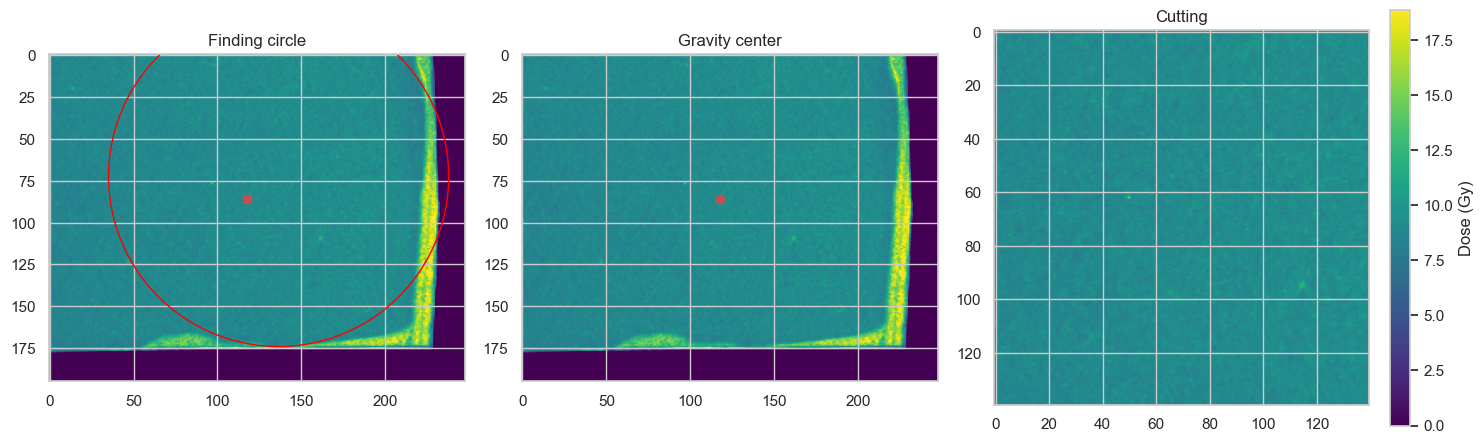

In [122]:
foil_init_size=TupleXY(150, 150)
r_envelope_start=250
max_radius=100
min_radius=100
cut_px=70

ebt3_cutting_params = {
    1:
    CuttingParameters(
        foil_init_center=TupleXY(2000, 150),
    ),
    2:
    CuttingParameters(
        foil_init_center=TupleXY(150, 150),
    ),
    3:
    CuttingParameters(
        foil_init_center=TupleXY(750, 150),
    ),
    4:
    CuttingParameters(
        foil_init_center=TupleXY(430, 150),
    ),
    5:
    CuttingParameters(
        foil_init_center=TupleXY(2025, 530),
    ),
    6:
    CuttingParameters(
        foil_init_center=TupleXY(2100, 950),
    ),
}


# loop over all cutting parameters and update cut_px in frozen dataclass, making an updated copy
for foil_id, params in ebt3_cutting_params.items():
    params = CuttingParameters(
        foil_init_center=params.foil_init_center,
        foil_init_size=foil_init_size,
        cut_px=cut_px,
        r_envelope_start=r_envelope_start,
        max_radius=max_radius,
        min_radius=min_radius
    )
    ebt3_cutting_params[foil_id] = params

foil_id = 6

data_cut, circle, cm, vmax, dose_cut_Gy = cut_detector_all_steps(im, ebt3_cutting_params[foil_id])


fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
im1 = axs[0].imshow(dose_cut_Gy, cmap='viridis', vmin=0, vmax=vmax)
axs[0].scatter(cm[1], cm[0], color='r');
axs[0].add_artist(
    plt.Circle(xy=(circle.x, circle.y),
               radius=circle.r,
               color='red',
               fill=False,
               transform=axs[0].transData))
axs[0].set_title('Finding circle')
im2 = axs[1].imshow(dose_cut_Gy, cmap='viridis', vmin=0, vmax=vmax)
axs[1].scatter(cm[1], cm[0], color='r');
axs[1].set_title('Gravity center')
im3 = axs[2].imshow(data_cut, cmap='viridis', vmin=0, vmax=vmax)
axs[2].set_title('Cutting')
fig.colorbar(im3, label='Dose (Gy)', fraction=0.05)
plt.tight_layout()

KeyError: 26

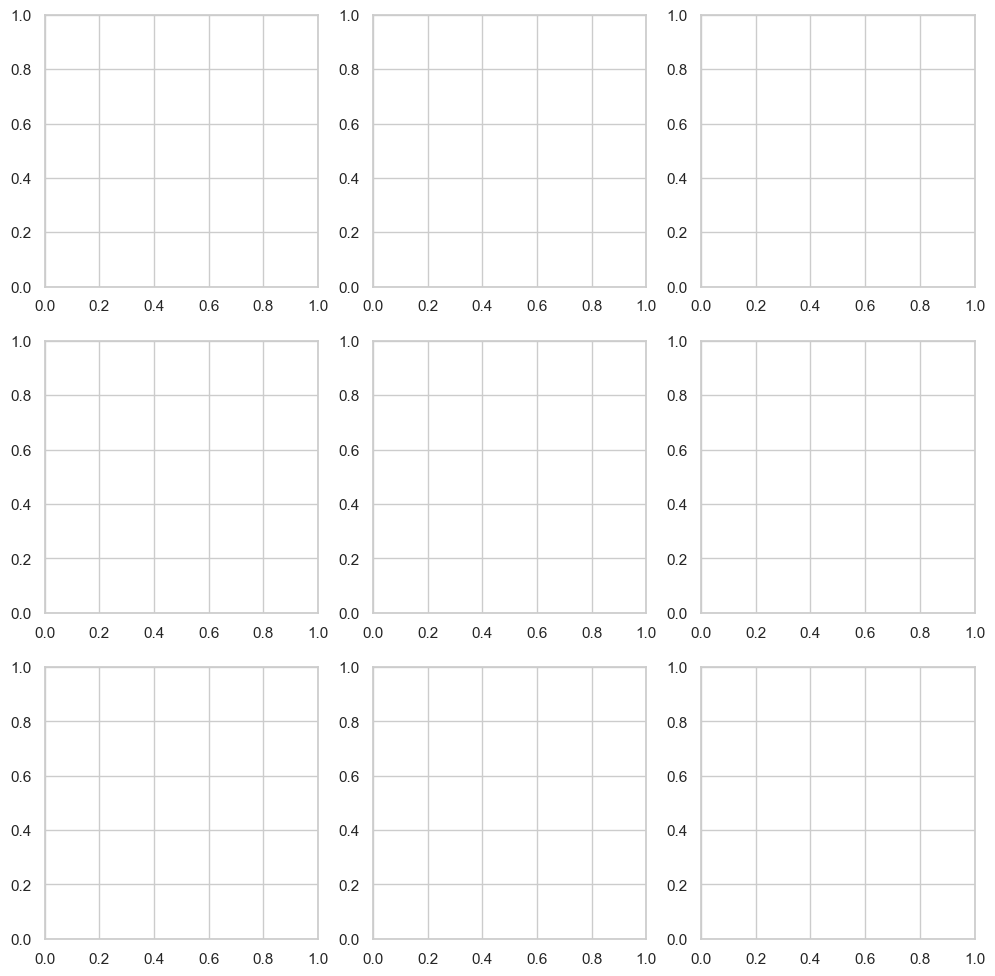

In [119]:
first_foil_no = 26
last_foil_no = 28

n_foils = last_foil_no - first_foil_no + 1

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(4*3, 4*n_foils))

vmax = 25

for i in range(first_foil_no, last_foil_no+1):
    foil_id = i - first_foil_no

    data_cut, circle, cm, _, dose_cut_Gy = cut_detector_all_steps(im, ebt3_cutting_params[i])

    im1 = axs[foil_id][0].imshow(dose_cut_Gy, cmap='viridis', vmin=0, vmax=vmax)
    axs[foil_id][0].scatter(cm[1], cm[0], color='r');
    axs[foil_id][0].add_artist(
        plt.Circle(xy=(circle.x, circle.y),
                radius=circle.r,
                color='red',
                fill=False,
                transform=axs[foil_id][0].transData))
    axs[foil_id][0].set_title(f'Finding circle det {i}')
    im2 = axs[foil_id][1].imshow(dose_cut_Gy, cmap='viridis', vmin=0, vmax=vmax)
    axs[foil_id][1].scatter(cm[1], cm[0], color='r');
    axs[foil_id][1].set_title(f'Gravity center det {i}')
    im3 = axs[foil_id][2].imshow(data_cut, cmap='viridis', vmin=0, vmax=vmax)
    axs[foil_id][2].set_title(f'Cutting det {i}')
    fig.colorbar(im3, label='Dose (Gy)', fraction=0.05)

In [30]:
ebt3_cutted_det = {}
for det_no, params in ebt3_cutting_params.items():
    _, _, _, _, dose_cut_Gy = cut_detector_all_steps(im, params)
    ebt3_cutted_det[det_no] = dose_cut_Gy

Circle found: Circle(x=177.5, y=231.5, r=30.899999618530273)
Circle found: Circle(x=108.5, y=122.5, r=63.900001525878906)
Circle found: Circle(x=173.5, y=36.5, r=50.70000076293945)


In [31]:
def radial_profile(data_cut: np.ndarray, px_to_mm: float, precision: int = 2) -> pd.DataFrame:
    r = []
    v = []
    cm = (data_cut.shape[0]//2, data_cut.shape[1]//2)
    for i in range(data_cut.shape[0]):
        for j in range(data_cut.shape[1]):
            v_to_cm = ((i - cm[0])**2 + (j - cm[1])**2)**0.5
            r.append(v_to_cm)
            v.append(data_cut[i, j])
    df_r = pd.DataFrame({'r': r, 'v': v})
    df_r['r_mm'] = df_r['r'] * px_to_mm 
    df_r['r_mm_round'] = df_r['r_mm'].round(precision)
    df_r['v_norm'] = df_r['v'] / df_r['v'][df_r['r_mm'] < 3].mean()
    df_r
    return df_r

-2.2770597008761215
-2.2761780044495983
-2.2768071728454014


Text(0.5, 1.0, 'Radial profile of EBT3 detectors')

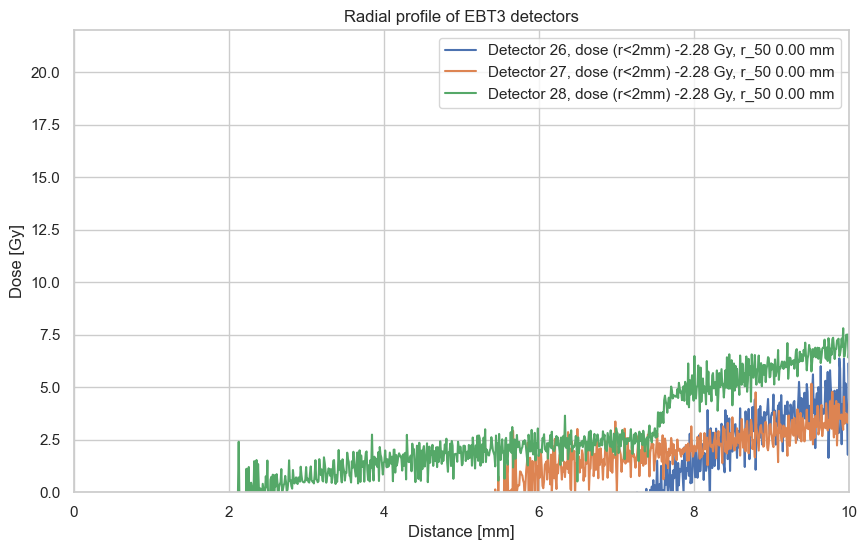

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(first_foil_no, last_foil_no+1):
    df_r = radial_profile(ebt3_cutted_det[i], ebt_px_to_mm, precision=2).groupby('r_mm_round').mean()
    mean_dose = df_r['v'][df_r['r_mm'] < 2].mean()
    print(mean_dose)
    # radius at which dose drops to mean_dose/2
    r_50 = df_r['r_mm'][df_r['v'] < mean_dose/2].min()
    df_r.plot(y='v', ax=ax, label=f'Detector {i}, dose (r<2mm) {mean_dose:.2f} Gy, r_50 {r_50:.2f} mm')
    ax.scatter(r_50, mean_dose/2, color='black')
    


ax.set_xlim(0,10)
ax.set_ylim(0,22)
ax.set_xlabel('Distance [mm]')
ax.set_ylabel('Dose [Gy]')
ax.legend()
ax.set_title('Radial profile of EBT3 detectors')

Circle found: Circle(x=177.5, y=231.5, r=30.899999618530273)
Circle found: Circle(x=108.5, y=122.5, r=63.900001525878906)


/tmp/ipykernel_20349/2415402383.py:22: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im3 = axs[foil_id].imshow(data_smooth, vmin=17, vmax=23, cmap='inferno')
/tmp/ipykernel_20349/2415402383.py:22: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im3 = axs[foil_id].imshow(data_smooth, vmin=17, vmax=23, cmap='inferno')


TypeError: Input z must be at least a (2, 2) shaped array, but has shape (0, 0)

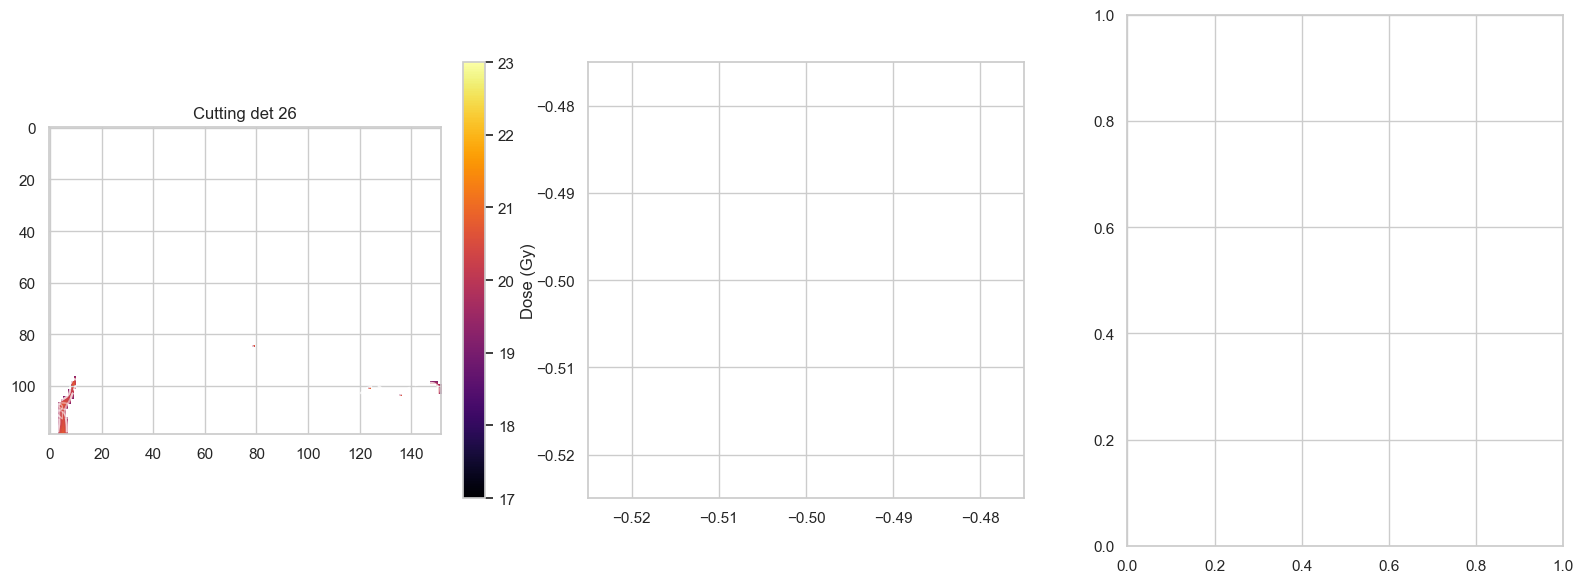

In [33]:
first_foil_no = 26
last_foil_no = 28

n_foils = last_foil_no - first_foil_no + 1

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

vmax = 25

for i in range(first_foil_no, last_foil_no+1):
    foil_id = i - first_foil_no

    data_cut, circle, cm, _, dose_cut_Gy = cut_detector_all_steps(im, ebt3_cutting_params[i])

    # smooth data_cut with gaussian filter 
    data_smooth = ndi.gaussian_filter(data_cut, sigma=2.0)
    dmax = 21
    dmin = 19
    data_smooth[data_smooth > dmax] = np.nan
    data_smooth[data_smooth < dmin] = np.nan

    im3 = axs[foil_id].imshow(data_smooth, vmin=17, vmax=23, cmap='inferno')
    # plot isodoses
    axs[foil_id].contour(data_smooth, levels=np.arange(17, 23, 1), colors='white', alpha=0.5)
    # add text labels on the isodose lines
    axs[foil_id].clabel(axs[foil_id].contour(data_smooth, levels=np.arange(17, 23, 1), colors='white', alpha=0.5), fmt='%2.0f')

    axs[foil_id].set_title(f'Cutting det {i}')
    fig.colorbar(im3, label='Dose (Gy)', fraction=0.05)
    fig.tight_layout()

# OSL MB 20 Gy entrance

In [31]:
# osl_mb_detector_df = pd.read_hdf(base_path / '2024-05-28_PB_silicon_20Gy' / 'data'  / 'interim' / 'PB_20Gy' / 'detectors_data.h5', key='df')
# osl_mb_detector_df.set_index('det_no', inplace=True)
# osl_mb_detector_df

In [32]:
# from lmfit.model import load_model, load_modelresult
# model = load_model(base_path / '2024-05-28_PB_silicon_20Gy' / 'data'  / 'interim' / 'PB_20Gy' / 'model.sav')
# model_result = load_modelresult(base_path / '2024-05-28_PB_silicon_20Gy' / 'data'  / 'interim' / 'PB_20Gy' / 'model_result.sav')
# model_result

In [33]:
# model_result.eval(params=model_result.params, x=np.array([20,30]))

In [34]:
osl_mb_data = base_path / 'publication_Measurement_2024' / 'analysis'  / 'interim' / '2024-09-18' / 'protons' / 'bg_sub_data'
osl_mb_data.exists()

True

In [35]:
osl_mb_images = {}
for det_no in {26,27,28}:
#for det_no in range(2, 13):
    det_im_signal = np.load(osl_mb_data / f'data_det{det_no:02d}.npy')
    det_im_Co60_eqv_dose = det_im_signal / (300/20)
    det_im_proton_dose = det_im_Co60_eqv_dose / 1
    osl_mb_images[det_no] = det_im_proton_dose

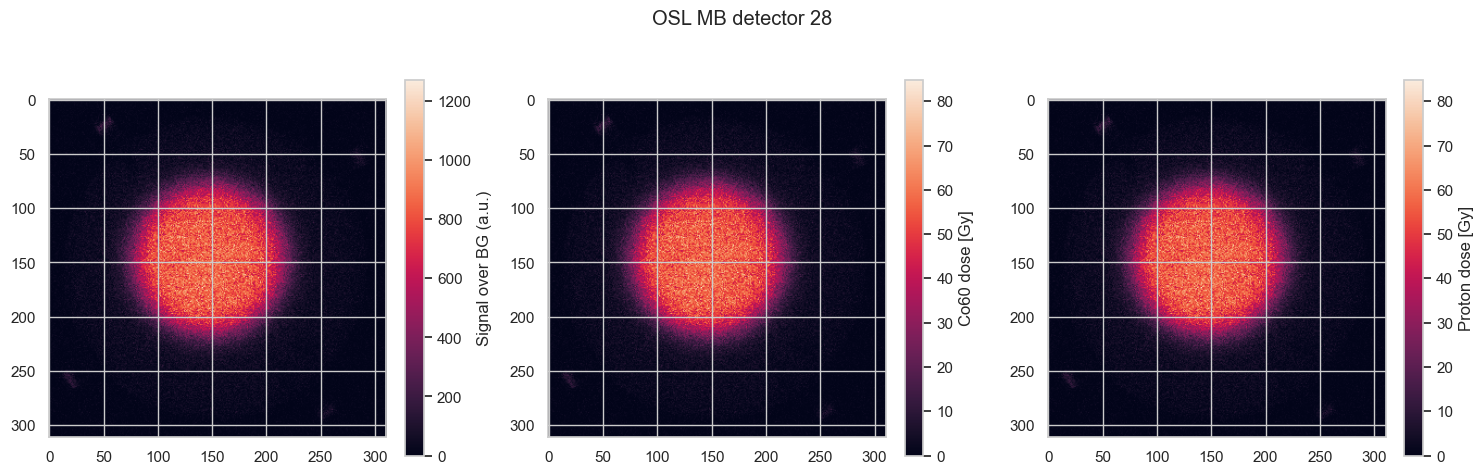

In [36]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
im1 = axs[0].imshow(det_im_signal, vmin=0)
im2 = axs[1].imshow(det_im_Co60_eqv_dose, vmin=0)
im3 = axs[2].imshow(det_im_proton_dose, vmin=0)
fig.suptitle(f'OSL MB detector {det_no}')

fig.colorbar(im1, label='Signal over BG (a.u.)', fraction=0.05)
fig.colorbar(im2, label='Co60 dose [Gy]', fraction=0.05)
fig.colorbar(im3, label='Proton dose [Gy]', fraction=0.05)

plt.tight_layout()

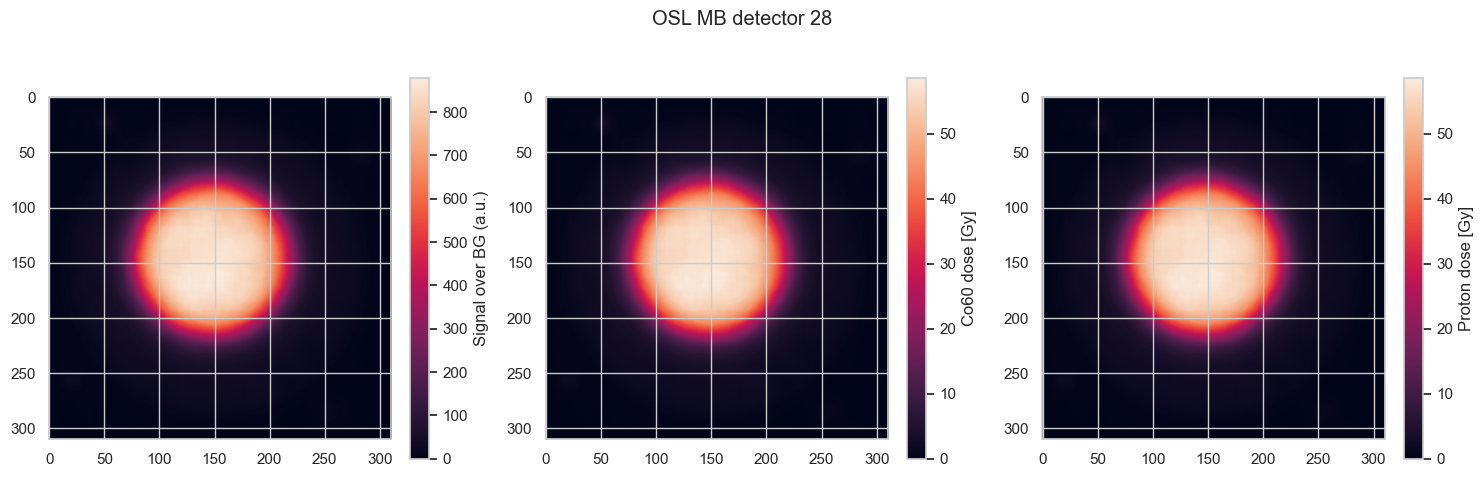

In [37]:
from scipy import signal
kernel = np.ones((19, 19))

# Apply median filter to each image data
det_im_signal_filtered = signal.medfilt2d(det_im_signal, kernel_size=kernel.shape)
det_im_Co60_eqv_dose_filtered = signal.medfilt2d(det_im_Co60_eqv_dose, kernel_size=kernel.shape)
det_im_proton_dose_filtered = signal.medfilt2d(det_im_proton_dose, kernel_size=kernel.shape)
# Create image plots with filtered data

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
im1 = axs[0].imshow(det_im_signal_filtered, vmin=0)
im2 = axs[1].imshow(det_im_Co60_eqv_dose_filtered, vmin=0)
im3 = axs[2].imshow(det_im_proton_dose_filtered, vmin=0)
fig.suptitle(f'OSL MB detector {det_no}')

fig.colorbar(im1, label='Signal over BG (a.u.)', fraction=0.05)
fig.colorbar(im2, label='Co60 dose [Gy]', fraction=0.05)
fig.colorbar(im3, label='Proton dose [Gy]', fraction=0.05)

plt.tight_layout()

Text(0.5, 1.0, 'OSL MB detector 28')

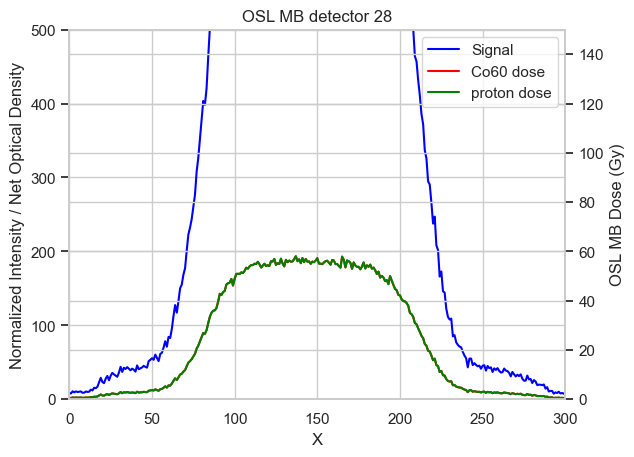

In [38]:
fig, ax = plt.subplots()
x_slice = slice(100,150)
ax.plot(det_im_signal[x_slice, :].mean(axis=0), label='Signal', color='blue')
ax_twin = ax.twinx()
ax_twin.plot(det_im_Co60_eqv_dose[x_slice, :].mean(axis=0), label='Co60 dose', color='red')
ax_twin.plot(det_im_proton_dose[x_slice, :].mean(axis=0), label='proton dose', color='green')
ax.set_xlabel('X')
ax.set_ylabel('Normalized Intensity / Net Optical Density')
ax_twin.set_ylabel('OSL MB Dose (Gy)')
ax.set_xlim(0, 300)
ax.set_ylim(0, 500)
ax_twin.set_ylim(0, 150)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
ax_twin.legend(lines + lines2, labels + labels2, loc=0)
ax.set_title(f'OSL MB detector {det_no}')

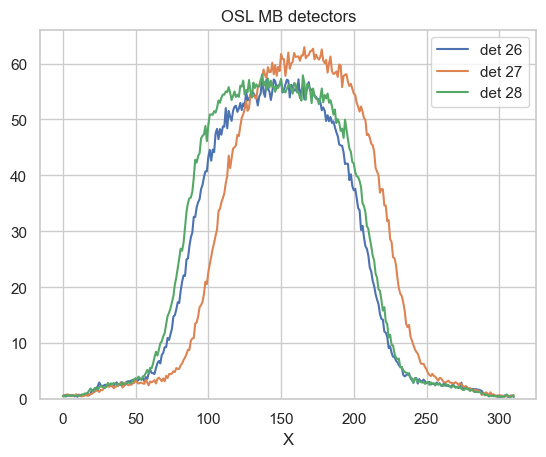

In [39]:
fig, ax = plt.subplots()
x_slice = slice(100,150)
for det_id in {26,27,28}:
    ax.plot(osl_mb_images[det_id][x_slice, :].mean(axis=0), label=f'det {det_id}')
ax.set_xlabel('X')
ax.set_ylim(0, None)
ax.set_title(f'OSL MB detectors')
ax.legend();

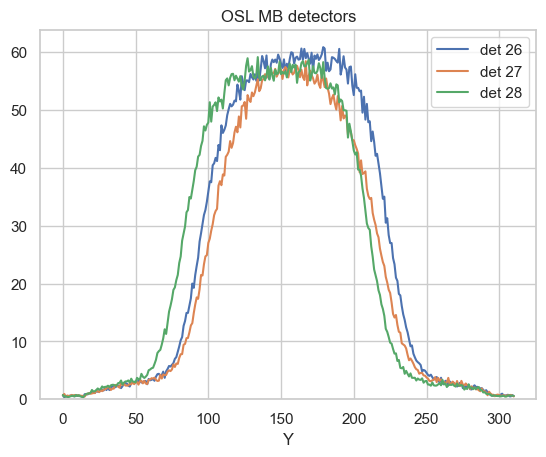

In [40]:
fig, ax = plt.subplots()
x_slice = slice(100,150)
for det_id in {26,27,28}:
    ax.plot(osl_mb_images[det_id][:, x_slice].mean(axis=1), label=f'det {det_id}')
ax.set_xlabel('Y')
ax.set_ylim(0, None)
ax.set_title(f'OSL MB detectors')
ax.legend();

Circle found: Circle(x=149.5, y=166.5, r=69.4000015258789)
Circle found: Circle(x=149.5, y=166.5, r=69.4000015258789), CM = (160.8048646942429, 148.13896311701208)
Circle found: Circle(x=134.5, y=126.5, r=68.30000305175781)
Circle found on cut: Circle(x=134.5, y=126.5, r=68.30000305175781), CM = (129.68057996420652, 130.5155456356471), shape = (260, 260)


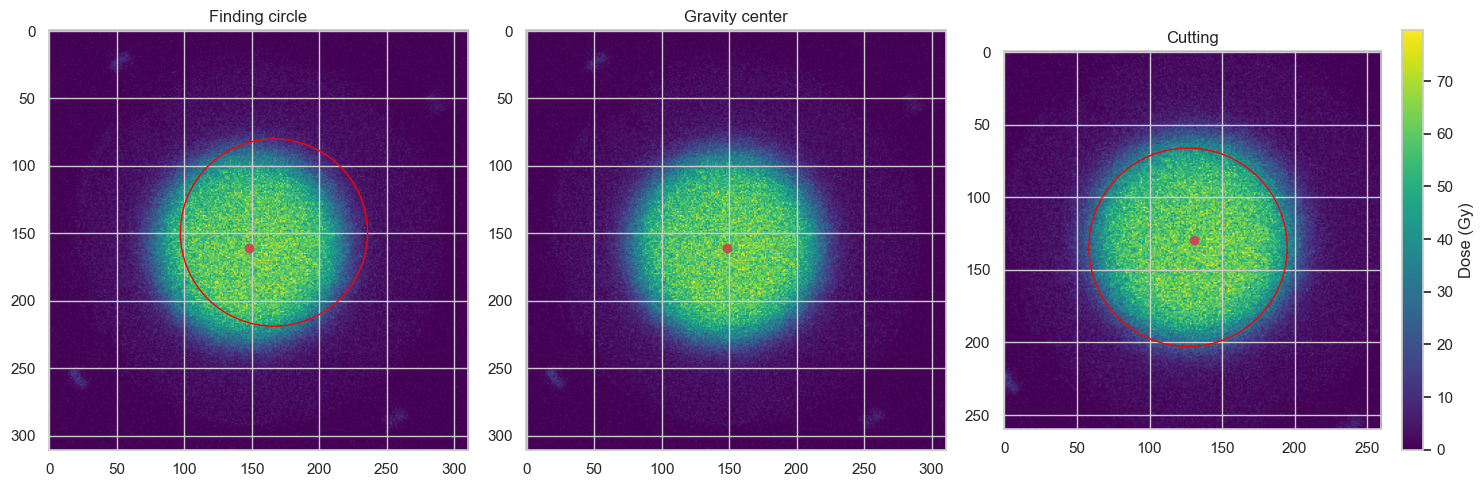

In [41]:
dose_cut_Gy = osl_mb_images[26]

params = CuttingParameters(
    foil_init_center=TupleXY(dose_cut_Gy.shape[0] // 2,
                             dose_cut_Gy.shape[1] // 2),
    foil_init_size=TupleXY(dose_cut_Gy.shape[0] // 2,
                           dose_cut_Gy.shape[1] // 2),
    cut_px=130)

circle = cut_detector_circle(dose_cut_Gy, max_radius=params.max_radius, min_radius=params.min_radius, nsigma=0.5)
mask = circle_mask(dose_cut_Gy, circle, params)
cm = cm_for_plotting(dose_cut_Gy, mask)

print(f'Circle found: {circle}, CM = {cm}')

vmax = vmax_for_plotting(dose_cut_Gy, mask)
data_cut = cut_detector(dose_cut_Gy, cm, params)

circle_on_cut = cut_detector_circle(data_cut, max_radius=params.max_radius, min_radius=params.min_radius, nsigma=0.4)
mask_on_cut = circle_mask(data_cut, circle_on_cut, params)
cm_on_cut = cm_for_plotting(data_cut, mask_on_cut)

print(f'Circle found on cut: {circle_on_cut}, CM = {cm_on_cut}, shape = {data_cut.shape}')

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
im1 = axs[0].imshow(dose_cut_Gy, cmap='viridis', vmin=0, vmax=vmax)
axs[0].scatter(cm[1], cm[0], color='r');
axs[0].add_artist(
    plt.Circle(xy=(circle.y, circle.x),
               radius=circle.r,
               color='red',
               fill=False,
               transform=axs[0].transData))
axs[0].set_title('Finding circle')
im2 = axs[1].imshow(dose_cut_Gy, cmap='viridis', vmin=0, vmax=vmax)
axs[1].scatter(cm[1], cm[0], color='r');
axs[1].set_title('Gravity center')
im3 = axs[2].imshow(data_cut, cmap='viridis', vmin=0, vmax=vmax)
axs[2].scatter(cm_on_cut[1], cm_on_cut[0], color='r');
axs[2].add_artist(
    plt.Circle(xy=(circle_on_cut.y, circle_on_cut.x),
               radius=circle_on_cut.r,
               color='red',
               fill=False,
               transform=axs[2].transData))
axs[2].set_title('Cutting')
fig.colorbar(im3, label='Dose (Gy)', fraction=0.05)
plt.tight_layout()

In [42]:
osl_mb_px_to_mm = 0.07211249531663806 

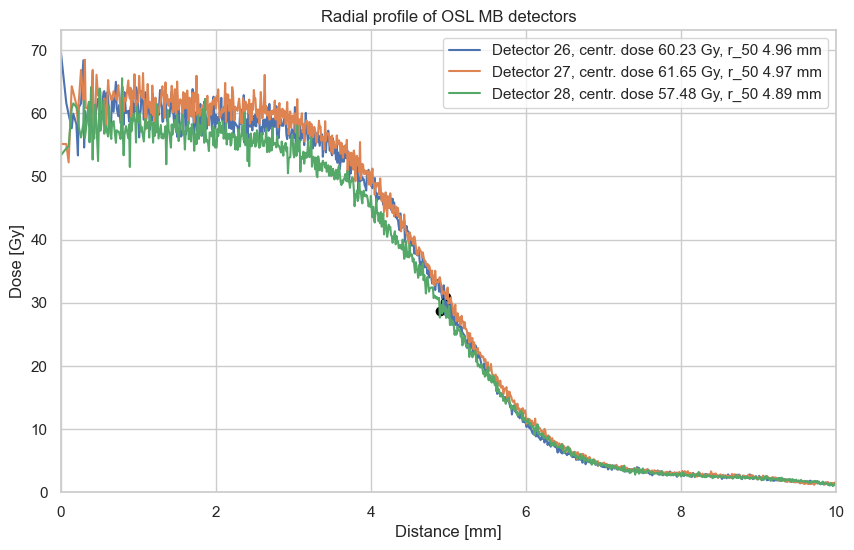

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))

for det_id, osl_mb_image in osl_mb_images.items():
    df_r = radial_profile(osl_mb_image, osl_mb_px_to_mm).groupby('r_mm_round').mean()
    mean_dose = df_r['v'][df_r['r_mm'] < 2].mean()
    # radius at which dose drops to mean_dose/2
    r_50 = df_r['r_mm'][df_r['v'] < mean_dose/2].min()
    df_r.plot(y='v', ax=ax, label=f'Detector {det_id}, centr. dose {mean_dose:.2f} Gy, r_50 {r_50:.2f} mm')
    ax.scatter(r_50, mean_dose/2, color='black')


ax.set_xlim(0,10)
ax.set_ylim(0,None)
ax.set_xlabel('Distance [mm]')
ax.set_ylabel('Dose [Gy]')
ax.legend()
ax.set_title('Radial profile of OSL MB detectors');

# OSL MB 20 Gy vs EBT3 profile

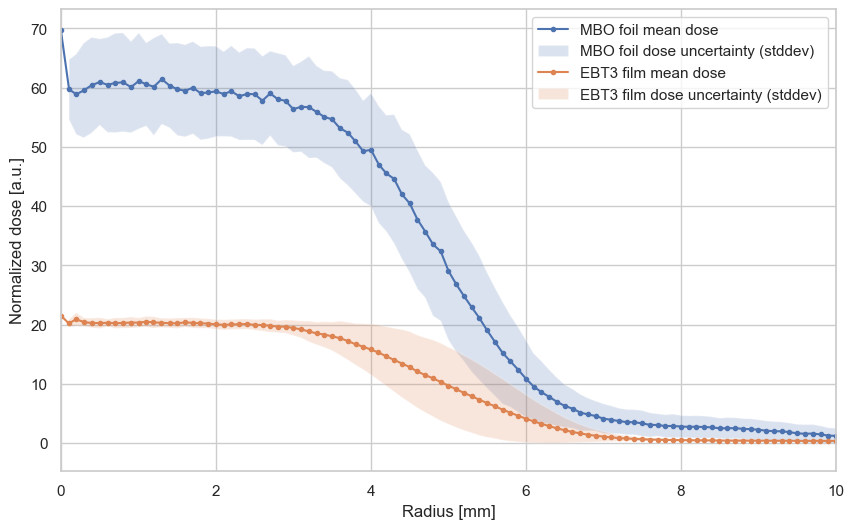

In [44]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')

ax.patch.set_alpha(0)

osl_mb_det_no = 26

precision=1

df_r = radial_profile(osl_mb_images[osl_mb_det_no], osl_mb_px_to_mm, precision=precision).groupby('r_mm_round').mean()
df_r_std = radial_profile(osl_mb_images[osl_mb_det_no], osl_mb_px_to_mm, precision=precision).groupby('r_mm_round').std()
mean_dose = df_r['v'][df_r['r_mm'] < 2].mean()
# radius at which dose drops to mean_dose/2
r_50 = df_r['r_mm'][df_r['v'] < mean_dose/2].min()
df_r['v_norm'] = df_r.v #/ mean_dose
df_r_std['v_norm'] = df_r_std.v #/ mean_dose
#df_r.plot(y='v_norm', ax=ax, label=f'OSL MB foil')

# Scatter plot for OSL MB foil
#ax.scatter(df_r['r_mm'], df_r['v_norm'], label=f'OSL MB foil', marker='.')
ax.plot(df_r['r_mm'], df_r['v_norm'], label=f'MBO foil mean dose', marker='.',)
ax.fill_between(df_r['r_mm'], df_r['v_norm'] - df_r_std['v_norm'], df_r['v_norm'] + df_r_std['v_norm'], alpha=0.2, label='MBO foil dose uncertainty (stddev)')

df_r = radial_profile(ebt3_cutted_det[26], ebt_px_to_mm, precision=precision).groupby('r_mm_round').mean()
df_r_std = radial_profile(ebt3_cutted_det[26], ebt_px_to_mm, precision=precision).groupby('r_mm_round').std()
df_r_std_low_q = radial_profile(ebt3_cutted_det[26], ebt_px_to_mm, precision=precision).groupby('r_mm_round').quantile(0.25)
df_r_std_high_q = radial_profile(ebt3_cutted_det[26], ebt_px_to_mm, precision=precision).groupby('r_mm_round').quantile(0.75)
mean_dose = df_r['v'][df_r['r_mm'] < 2].mean()
# radius at which dose drops to mean_dose/2
r_50 = df_r['r_mm'][df_r['v'] < mean_dose/2].min()
df_r['v_norm'] = df_r.v #/ mean_dose
df_r_std['v_norm'] = df_r_std.v #/ mean_dose
#ax.scatter(df_r['r_mm'], df_r['v_norm'], label=f'EBT3 foil', marker='.')
ax.plot(df_r['r_mm'], df_r['v_norm'], label=f'EBT3 film mean dose', marker='.')
ax.fill_between(df_r['r_mm'], df_r['v_norm'] - df_r_std['v_norm'], df_r['v_norm'] + df_r_std['v_norm'], alpha=0.2, label='EBT3 film dose uncertainty (stddev)')
#ax.fill_between(df_r['r_mm'], df_r_std_low_q['v_norm'], df_r_std_high_q['v_norm'], alpha=0.2)


ax.set_xlim(0,10)
#ax.set_ylim(0,1.1)
ax.set_xlabel('Radius [mm]')
ax.set_ylabel('Normalized dose [a.u.]')
ax.legend()
#ax.set_title('Radial profile of OSL MB and EBT3 detectors');

fig.savefig(base_path / 'publication_Measurement_2024' / 'analysis'  / 'ebt_vs_ms.svg')